# DMW_A4

## A One-Class Classification decision Tree based on kernel density estimation

------

## Group members:

IIT2018176 (Milan Bhuva)

IIT2018178 (Manav Agrawal)

IIT2018179 (Mohammed Aadil)

IIT2018202 (Ankit Rauniyar)

------

### Imporing the Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score 
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import tree

### Loading data from CSV

In [2]:
df = pd.read_csv("iris.csv")
data = df.to_numpy()

df

,slength,swidth,plength,pwidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


### Visualizing the data

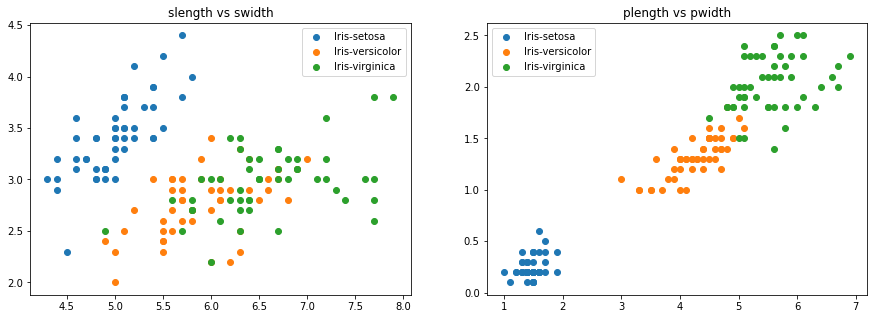

In [3]:
plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plt.scatter(data[data[:,4] == 'Iris-setosa'][:,0], data[data[:,4] == 'Iris-setosa'][:,1])
plt.scatter(data[data[:,4] == 'Iris-versicolor'][:,0], data[data[:,4] == 'Iris-versicolor'][:,1])
plt.scatter(data[data[:,4] == 'Iris-virginica'][:,0], data[data[:,4] == 'Iris-virginica'][:,1])
plt.legend(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'])
plt.title('slength vs swidth')

plt.subplot(1,2,2)
plt.scatter(data[data[:,4] == 'Iris-setosa'][:,2], data[data[:,4] == 'Iris-setosa'][:,3])
plt.scatter(data[data[:,4] == 'Iris-versicolor'][:,2], data[data[:,4] == 'Iris-versicolor'][:,3])
plt.scatter(data[data[:,4] == 'Iris-virginica'][:,2], data[data[:,4] == 'Iris-virginica'][:,3])
plt.legend(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'])
plt.title('plength vs pwidth')

plt.show()

------

### Utility functions

In [4]:
def onevall(data, c):
    temp_Data = np.copy(data)
    Class = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
    
    for i in range(3):
        if i == c:
            temp_Data[:,4][temp_Data[:, 4] == Class[c]] = 0
        else:
            temp_Data[:,4][temp_Data[:, 4] == Class[i]] = 1    
    
    return temp_Data[:, :4], temp_Data[:,-1]

def OCCOVR(X_train, X_test, y_train, y_test):
    model = OneClassSVM(gamma='scale', nu=0.01)

    X_train = X_train[y_train==0]
    model.fit(X_train)


    yhat = model.predict(X_test)


    y_test[y_test == 1] = -1
    y_test[y_test == 0] = 1

    score = f1_score(y_test.astype(np.int64), yhat, pos_label=-1)
    
    return score

def iforestOVR(X_train, X_test, y_train, y_test):
    model = IsolationForest()
    
    X_train = X_train[y_train==0]
    model.fit(X_train)
    
    
    yhat = model.predict(X_test)
    
    
    y_test[y_test == 1] = -1
    y_test[y_test == 0] = 1
    
    score = f1_score(y_test.astype(np.int64), yhat, pos_label=-1)

    return score

# make a prediction with a KDE model
def KDE_predict(model, trainX, testX):
    composite = np.vstack((trainX, testX))
    
    yhat = model.fit_predict(composite)
    
    return yhat[len(trainX):]


def KDEOVR(X_train, X_test, y_train, y_test):
    model = LocalOutlierFactor(contamination=0.5)
    
    X_train = X_train[y_train==0]
    
    yhat = KDE_predict(model, X_train, X_test)

    
    y_test[y_test == 1] = -1
    y_test[y_test == 0] = 1

    
    score = f1_score(y_test.astype(np.int64), yhat, pos_label=-1)
    
    return score

def OCTree_feature_selection(X_train, X_test, y_train, y_test):
    dt = tree.DecisionTreeClassifier(max_depth=8, min_samples_leaf=5, random_state=0)
    
    X_train_float = np.array(X_train).astype("float")
    y_train_int = np.array(y_train).astype("int")

    dt.fit(X_train_float, y_train_int)

    res = dt.predict(X_test)
    res = res.astype(int)
    res = np.reshape(res, len(res))
    
    y_test = np.reshape(y_test, len(y_test))

    misclass = np.bitwise_xor(res, y_test)
    misclass = misclass.astype(float)

    aux = sum(misclass)/len(X_test)
    
    importances = dt.feature_importances_        
    indices = np.nonzero(importances)

            
    X_train_float = X_train_float[:,indices]    
    X_train_float = np.copy(X_train_float[:,0])
        
    X_test = X_test[:,indices]
    X_test = np.copy(X_test[:,0])
    
    return aux, X_test, res

def results(y_test, res):
    y = y_test.astype("int")

    auc = roc_auc_score(y, res)
    acc = accuracy_score(y, res) 
    print ("Acc: %.2f, ROC/AUC: %.2f" % (acc, auc))

    prec = precision_score(y, res, average='macro')
    recall = recall_score(y, res, average='macro')
    f1 = f1_score(y, res, average='macro')
    print ("Average   - Prec: %.2f, Recall: %.2f, F1: %.2f" % (prec, recall, f1))

    prec = precision_score(y, res, average='binary', pos_label=0)
    recall = recall_score(y, res, average='binary', pos_label=0)
    f1 = f1_score(y, res, average='binary', pos_label=0)
    print ("Pos_lab:0 - Prec: %.2f, Recall: %.2f, F1: %.2f" % (prec, recall, f1))

    prec = precision_score(y, res, average='binary', pos_label=1)
    recall = recall_score(y, res, average='binary', pos_label=1)
    f1 = f1_score(y, res, average='binary', pos_label=1)
    print ("Pos_lab:1 - Prec: %.2f, Recall: %.2f, F1: %.2f" % (prec, recall, f1))

------

### Data Pre-Processing

In [5]:
X_0, y_0 = onevall(data, 0)
X_1, y_1 = onevall(data, 1)
X_2, y_2 = onevall(data, 2)

X_0_train, X_0_test, y_0_train, y_0_test = train_test_split(X_0, y_0, test_size=0.30, random_state=42)
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size=0.30, random_state=42)
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.30, random_state=42)

------

### Models Training and Testing

#### One Class Classification using One v All 

In [6]:
f1_0 = OCCOVR(X_0_train, X_0_test, y_0_train, y_0_test)
f1_1 = OCCOVR(X_1_train, X_1_test, y_1_train, y_1_test)
f1_2 = OCCOVR(X_2_train, X_2_test, y_2_train, y_2_test)

X_0, y_0 = onevall(data, 0)
X_1, y_1 = onevall(data, 1)
X_2, y_2 = onevall(data, 2)

X_0_train, X_0_test, y_0_train, y_0_test = train_test_split(X_0, y_0, test_size=0.30, random_state=42)
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size=0.30, random_state=42)
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.30, random_state=42)

#### Result

In [7]:
res_OCC = (f1_0+f1_1+f1_2)/3

#### Isolation forest using One v All

In [8]:
f1_0 = iforestOVR(X_0_train, X_0_test, y_0_train, y_0_test)
f1_1 = iforestOVR(X_1_train, X_1_test, y_1_train, y_1_test)
f1_2 = iforestOVR(X_2_train, X_2_test, y_2_train, y_2_test)

X_0, y_0 = onevall(data, 0)
X_1, y_1 = onevall(data, 1)
X_2, y_2 = onevall(data, 2)

X_0_train, X_0_test, y_0_train, y_0_test = train_test_split(X_0, y_0, test_size=0.30, random_state=42)
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size=0.30, random_state=42)
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.30, random_state=42)

#### Result

In [9]:
res_iforest = (f1_0+f1_1+f1_2)/3

#### KDE using One v All

In [10]:
f1_0 = KDEOVR(X_0_train, X_0_test, y_0_train, y_0_test)
f1_1 = KDEOVR(X_1_train, X_1_test, y_1_train, y_1_test)
f1_2 = KDEOVR(X_2_train, X_2_test, y_2_train, y_2_test)

X_0, y_0 = onevall(data, 0)
X_1, y_1 = onevall(data, 1)
X_2, y_2 = onevall(data, 2)

X_0_train, X_0_test, y_0_train, y_0_test = train_test_split(X_0, y_0, test_size=0.30, random_state=42)
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size=0.30, random_state=42)
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.30, random_state=42)

#### Result

In [11]:
res_KDE = (f1_0+f1_1+f1_2)/3

------

### Final results of 3 reference models

In [12]:
print("FINAL RESULTS OF THE 3 MODELS : ")
print("F1 score for OCC : \t", res_OCC)
print("F1 score for iforest : \t", res_iforest)
print("F1 score for KDE : \t", res_KDE)

FINAL RESULTS OF THE 3 MODELS : 
F1 score for OCC : 	 0.911529432223285
F1 score for iforest : 	 0.93208779524569
F1 score for KDE : 	 0.7629261701116655


------

### Proposed Model - OC-Tree

In [13]:
aux_0, X_0_test_new, res_0 = OCTree_feature_selection(X_0_train, X_0_test, y_0_train, y_0_test)
aux_1, X_1_test_new, res_1 = OCTree_feature_selection(X_1_train, X_1_test, y_1_train, y_1_test)
aux_2, X_2_test_new, res_2 = OCTree_feature_selection(X_2_train, X_2_test, y_2_train, y_2_test)

print ("Misclassified samples:", aux_0)
print ("Misclassified samples:", aux_1)
print ("Misclassified samples:", aux_2)

Misclassified samples: 0.0
Misclassified samples: 0.0
Misclassified samples: 0.022222222222222223


### Results of Proposed Model

In [14]:
print("For Class 0 vs Rest")
results(y_0_test, res_0)

print("\nFor Class 1 vs Rest")
results(y_1_test, res_1)

print("\nFor Class 2 vs Rest")
results(y_2_test, res_2)

For Class 0 vs Rest
Acc: 1.00, ROC/AUC: 1.00
Average   - Prec: 1.00, Recall: 1.00, F1: 1.00
Pos_lab:0 - Prec: 1.00, Recall: 1.00, F1: 1.00
Pos_lab:1 - Prec: 1.00, Recall: 1.00, F1: 1.00

For Class 1 vs Rest
Acc: 1.00, ROC/AUC: 1.00
Average   - Prec: 1.00, Recall: 1.00, F1: 1.00
Pos_lab:0 - Prec: 1.00, Recall: 1.00, F1: 1.00
Pos_lab:1 - Prec: 1.00, Recall: 1.00, F1: 1.00

For Class 2 vs Rest
Acc: 0.98, ROC/AUC: 0.98
Average   - Prec: 0.96, Recall: 0.98, F1: 0.97
Pos_lab:0 - Prec: 0.93, Recall: 1.00, F1: 0.96
Pos_lab:1 - Prec: 1.00, Recall: 0.97, F1: 0.98


### F1 score of the OC-Tree Model

In [15]:
avg_F1 = (0.97 + 0.96 + 0.98)/3
print("F1 score for OC-Tree :", avg_F1)

F1 score for OC-Tree : 0.9700000000000001
